# Using wind and rainfall as a discriminator for damage

This notebook explores the potential of using rainfall and wind speed data as a discriminator for damage to buildings. 

The "forecast" is the Bureau of Meteorology Atmospheric high-resolution Regional Reanalysis for Australia (BARRA), and uses four different measures of wind speed and rainfall:
* Surface wind gust (PSWG)
* Surface "mean" wind (PSMW)
* 900 hPa wind speed (PGWS)
* "Neighbourhood" surface wind gust (NSWG)
* Maximum instantaneous rainfall rate (PIRR)
* Maximum 1-hour rainfall rate (P1RR)
* Maximum 6-hour rainfall rate (P6RR)
* Event total rainfall accumulation (PTEA)
* "Neighbourhood" 1 -hour rainfall rate (N1RR)

These fields are all extracted from 10-minute time step fields (provided by David Wilke). 

The "Neighbourhood" fields apply a spatial filter that takes the highest value within a prescribed radius of each point and assigns it to that point. In this case, the radius has been set at approximately 0.36$^{\circ}$ (40 km).

The codes following each line above are the variable name as used throughout this notebook, and the field names in the input shape file.

First load the required modules for the calculation

In [1]:
%matplotlib inline

import os
from os.path import join as pjoin

from itertools import product

import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context("poster")
from matplotlib import colors
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


Set the data paths and read the data into a geoDataFrame

In [2]:
data_path = "X:/georisk/HaRIA_B_Wind/projects/impact_forecasting/data/impact/dungog"
data_path = "C:/WorkSpace/data/impact"
filename = "damage_hazard.shp"
filepath = pjoin(data_path, filename)

gdf = gpd.read_file(filepath)

DMG_ORDER=['No Damage - 0%','Minor Impact - 1-25%', 'Major Impact - 26-50%', 'Severe Impact - 51-75%','Destroyed - 76-100%']


Drop any records where the hazard variables are null. This removes any records outside the extent of the BARRA-SY grid, but I do not think there are any in this case. 

In [3]:
gdf.dropna(axis=0, inplace=True, subset=['PIRR', 'P1RR', 'N1RR', 'P6RR', 'PTEA',
                                         'PSWG', 'PSMW', 'NSWG', 'PGWS'])

In the first instance, we simply want to model the probability of buildings being damaged or undamaged. To do this, we add a numeric field to represent those buildings that are either classified as "Major Impact", "Severe Impact" or "Destroyed".

In [4]:
damaged = np.zeros(len(gdf))
damaged[gdf['EICU_Degda'].isin(['Destroyed - 76-100%', 
                                 'Severe Impact - 51-75%', 
                                 'Major Impact - 26-50%', 
                                 ])] = 1

gdf['Damaged'] = damaged

Define the list of variables representing rainfall and wind speed. 

In [5]:
rainfall = ['PIRR', 'P1RR', 'N1RR', 'P6RR', 'PTEA']
wind = ['PSWG', 'PSMW', 'NSWG', 'PGWS']

Now we cycle through the combinations of rainfall and wind variables, and calculate a quadratic discriminant analysis, with these as the predictor variables and the 'Damaged' variable as the predictand. This produces a 5 x 4 plot, with each panel represeting the QDA using a unique combination of rainfall and wind variables. In each, the wind variable is on the horizontal axis and the rainfall variable on the vertical axis. The shading represents the probabilty of being in the "Damaged" category.

C:\WorkSpace\anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


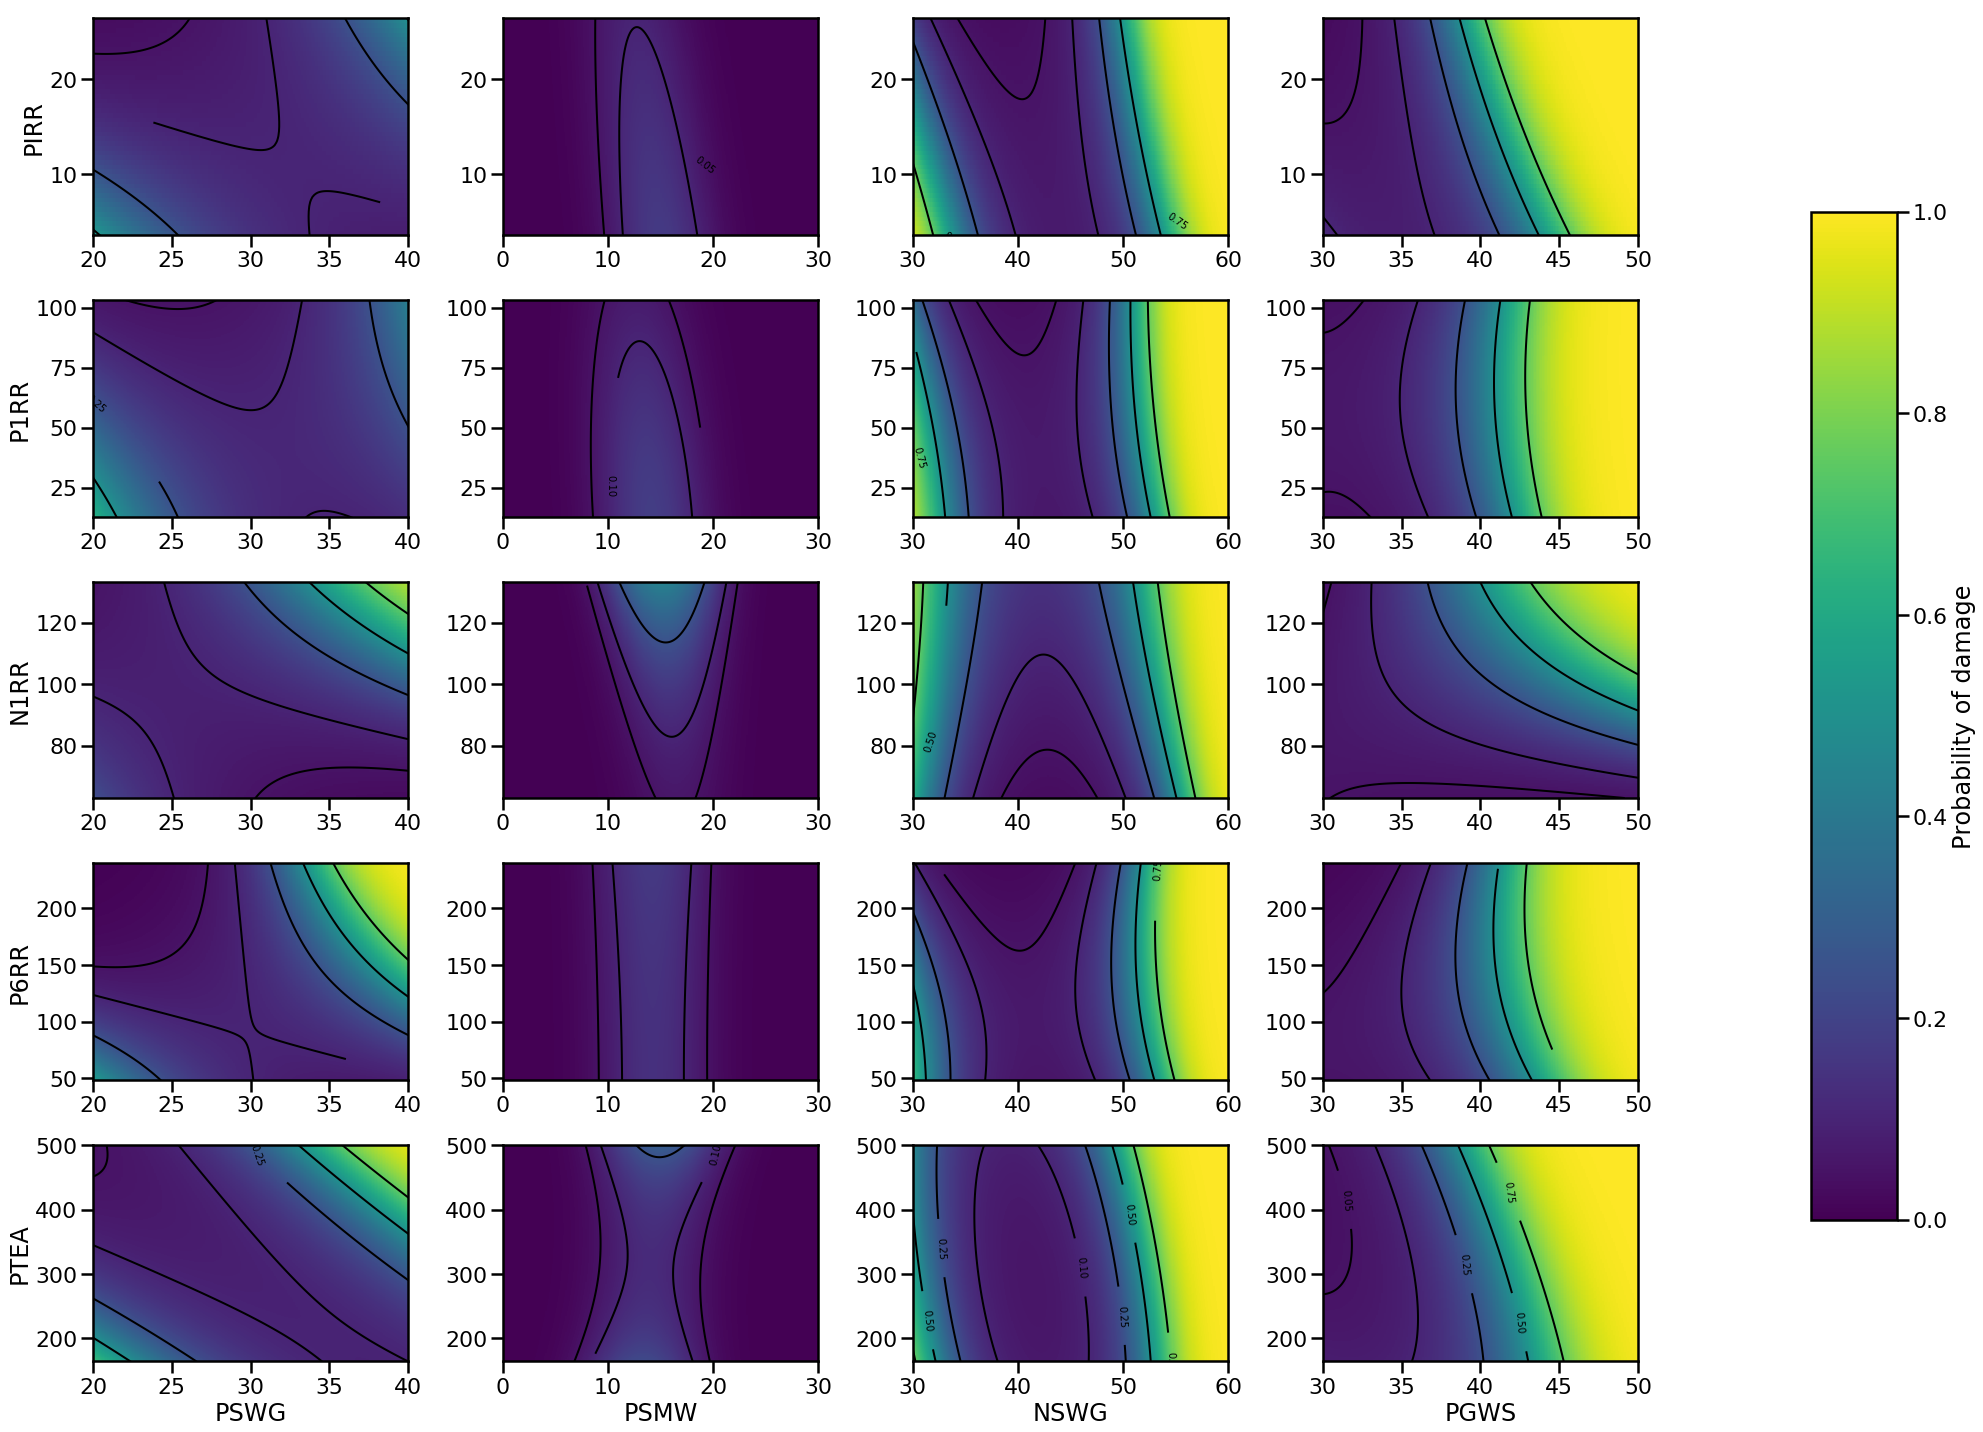

In [6]:
fig, axes = plt.subplots(5,4, figsize=(24,20),facecolor='white')
ax = axes.flatten()
xx = np.linspace(0, 100, 1000)
yy = np.linspace(0, 500, 1000)
xp, yp = np.meshgrid(xx, yy)
for i, (r, w) in enumerate(product(rainfall, wind)):
    X = np.array([gdf[w].values, gdf[r].values]).T
    y = gdf['Damaged'].values
    clf = QDA()
    clf.fit(X, y)
    Z = clf.predict_proba(np.c_[xp.ravel(), yp.ravel()])
    Z = Z[:, 1].reshape(xp.shape)
    cm = ax[i].pcolormesh(xp, yp, Z, cmap='viridis', norm=colors.Normalize(0., 1))
    cs = ax[i].contour(xp, yp, Z, [0.05, 0.1, 0.25,0.5, 0.75], linewidths=2., colors='k')
    ax[i].clabel(cs, fmt='%.2f')
    #ax[i].colorbar(cm, label="Probability of damage")
    if i>15:
        ax[i].set_xlabel(w)
    if i%4 == 0:
        ax[i].set_ylabel(r)
    ax[i].set_xlim((np.floor(gdf[w].values.min()/10)*10, 
                    np.ceil(gdf[w].values.max()/10)*10))
    ax[i].set_ylim((gdf[r].values.min(), gdf[r].values.max()*1.1,))

cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])
fig.colorbar(cm, cax=cbar_ax, label="Probability of damage")
fig.tight_layout()
fig.subplots_adjust(wspace=0.3, hspace=0.3,right=0.95)


Each panel above describes the probability of being "Damaged", given the incident wind speed measure (horizontal axis) and rainfall measure (vertical axis). Note that the bounds on each axis vary for each variable.

We now consider one of these panels for more deteailed investigation. The `PGWS` and `PIRR` variables give what we would intuitively expect to see from a predictor of damage - increasing probability for increasing values of the two predicor variables. 

This next section focuses on determining a discriminant function that we might be able to implement into an impact-forecasting workflow.

We take a threshold of 50% probability of damage as our reference point. The figure below plots the contour that we're looking for. Note that it produces two contours on this figure, and we will take the longer of the two to derive the discriminant function.

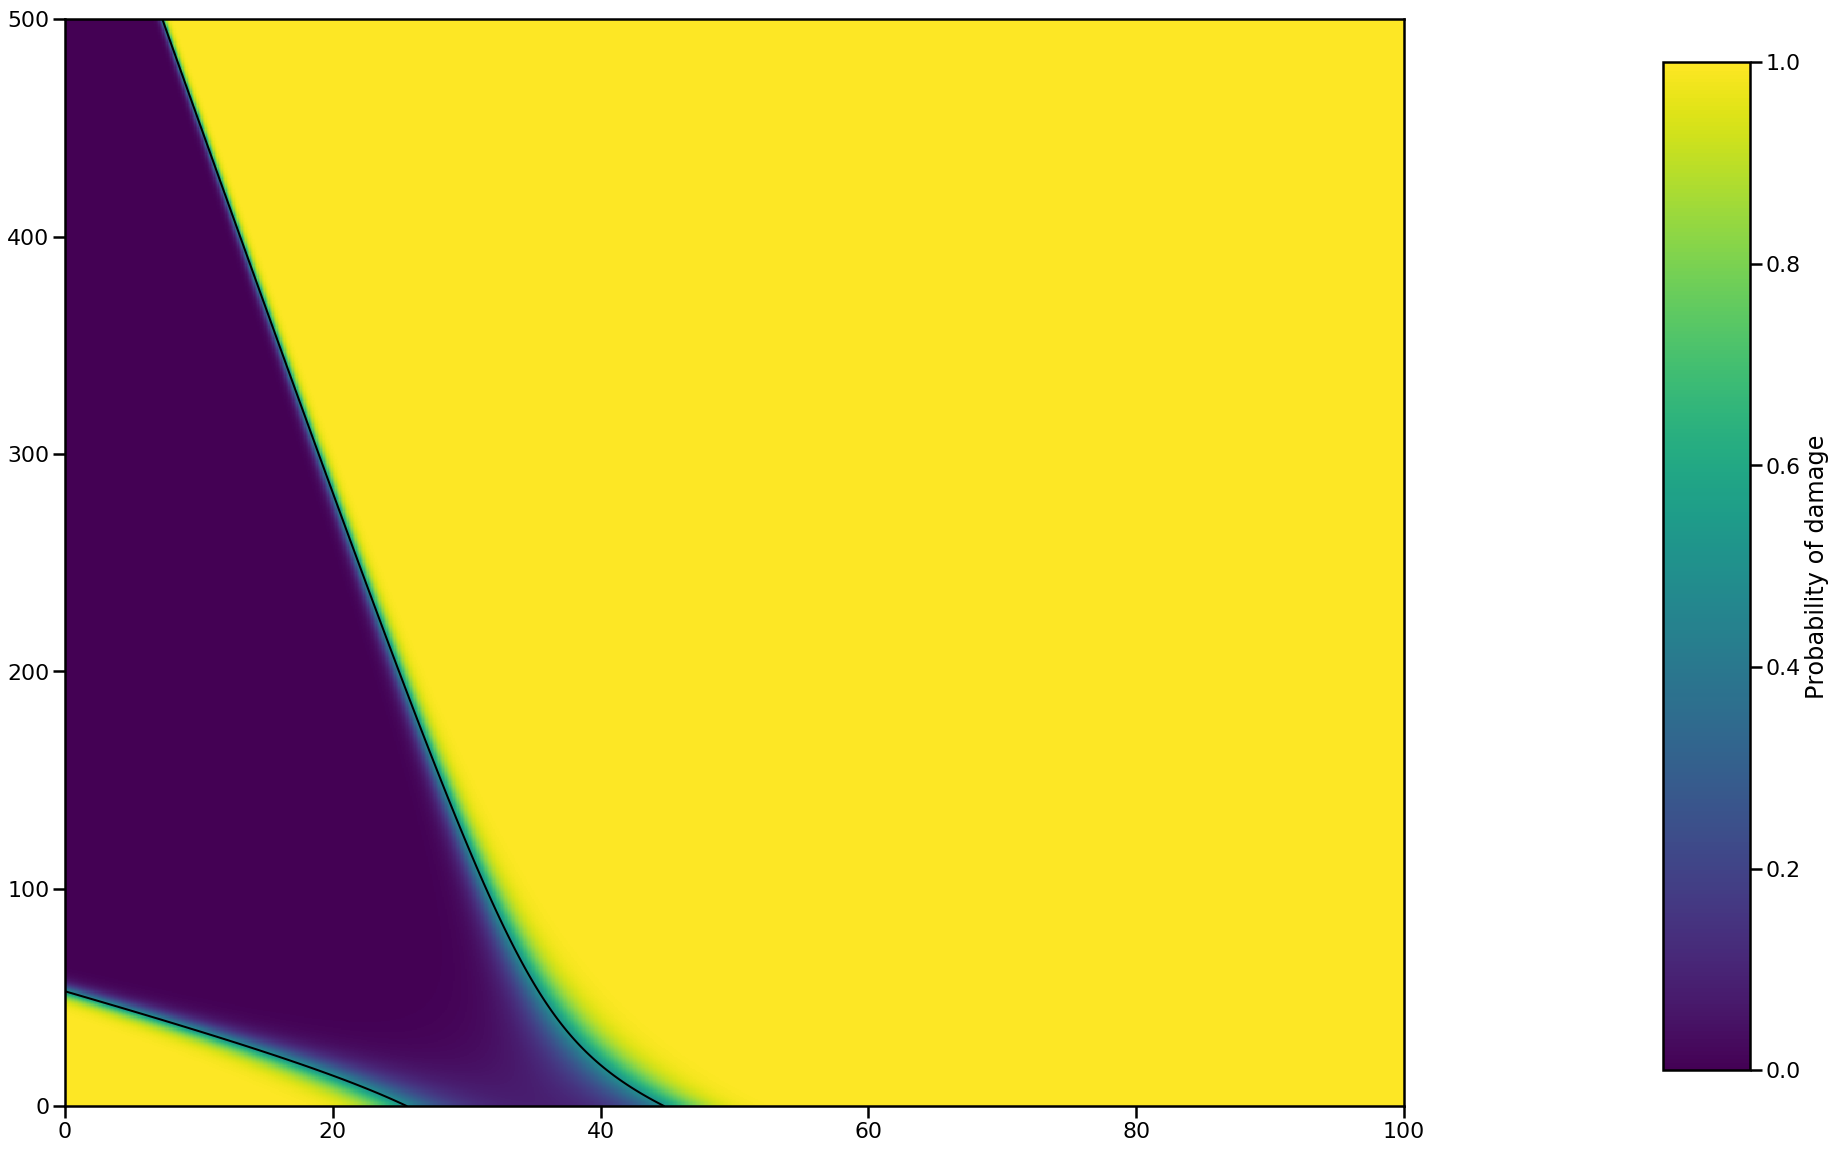

In [7]:
fig, axes = plt.subplots(1,1,figsize=(24,20),facecolor='white')
ax = axes

xx = np.linspace(0, 100, 1000)
yy = np.linspace(0, 500, 1000)
xp, yp = np.meshgrid(xx, yy)
xvar = 'PGWS'
yvar = 'PIRR'
X = np.array([gdf[xvar].values, gdf[yvar].values]).T
y = gdf['Damaged'].values
clf = QDA()
clf.fit(X, y)
Z = clf.predict_proba(np.c_[xp.ravel(), yp.ravel()])
Z = Z[:, 1].reshape(xp.shape)
cm = ax.pcolormesh(xp, yp, Z, cmap='viridis', norm=colors.Normalize(0., 1))
cs = ax.contour(xp, yp, Z, [0.5], linewidths=2., colors='k')
cbar_ax = fig.add_axes([1.05, 0.15, 0.05, 0.7])

fig.colorbar(cm, cax=cbar_ax, label="Probability of damage")

In [8]:
def get_contour_verts(cn):
    contours = []
    # for each contour line
    for cc in cn.collections:
        paths = []
        # for each separate section of the contour line
        for pp in cc.get_paths():
            xy = []
            # for each segment of that section
            for vv in pp.iter_segments():
                xy.append(vv[0])
            paths.append(np.vstack(xy))
        contours.append(paths)

    return contours

In [9]:
cn = get_contour_verts(cs)[0][1][:-1]

The `cn` variable is a list of vertices of the 0.5 probability contour in the above plot. I have selected the second contour (by first inspecting the full set of returned vertices), and the last vertex is dropped, as it is repeated (which will cause problems with the curve fitting in the next step). 

In [10]:
def func(x, a, b, c):
    value = (a/(x + b)) + c
    return value

In [11]:
popt, pcov = curve_fit(func, cn[:,0], cn[:,1], maxfev=100000)
print(popt)
print(pcov)

[ 6.42565626e+04  4.42407501e+01 -7.41200652e+02]
[[ 4.05119715e+08  2.06903266e+05 -2.96994999e+06]
 [ 2.06903266e+05  1.06412496e+02 -1.50836555e+03]
 [-2.96994999e+06 -1.50836555e+03  2.18813210e+04]]


Text(0, 0.5, 'PIRR')

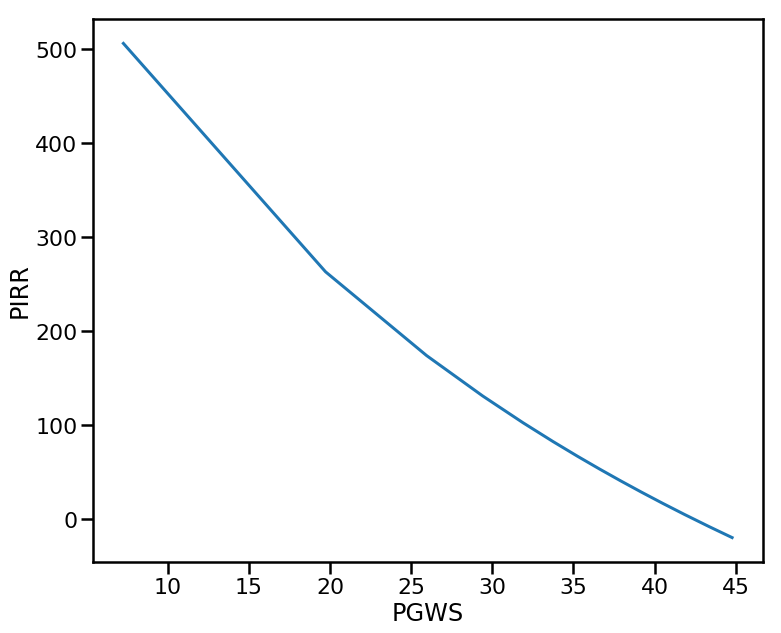

In [12]:
fig, axes = plt.subplots(1,1,figsize=(12,10),facecolor='white')
plt.plot(cn[:,0], func(cn[:,0], *popt))
plt.xlabel(xvar)
plt.ylabel(yvar)

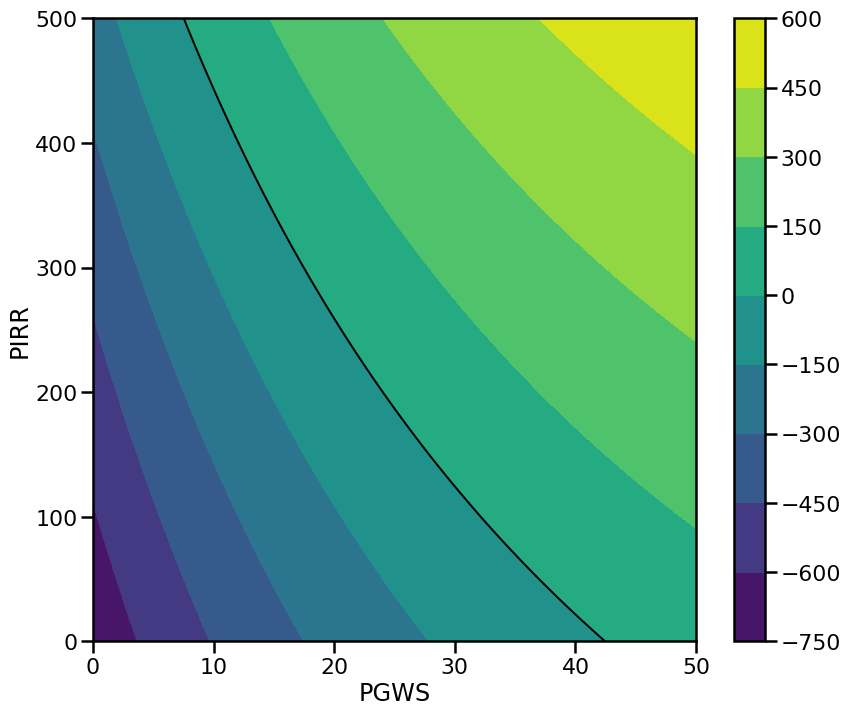

In [13]:
fig, axes = plt.subplots(1,1,figsize=(12,10),facecolor='white')
xx2 = np.linspace(0, 50, 1000)
yy2 = np.linspace(0, 500, 1000)
xp2, yp2 = np.meshgrid(xx2, yy2)

Z2 = np.c_[yp2.ravel()] - func(np.c_[xp2.ravel()], *popt)
Z2 = Z2.reshape(xp2.shape)
plt.contour(xp2, yp2, Z2, [0], linewidths=2., colors='k')
plt.contourf(xp2, yp2, Z2, levels=10, cmap='viridis',)
plt.colorbar()
plt.xlabel(xvar)
plt.ylabel(yvar)
plt.tight_layout()
plt.savefig(pjoin(data_path, 'predictor.png'))

In [14]:
def dmgthresh(pswg, pirr):
    v = (popt[0]/(pswg + popt[1])) + popt[2] - pirr
    return v

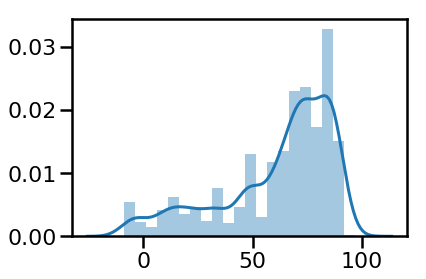

In [15]:
dmg = dmgthresh(gdf[xvar].values, gdf[yvar].values)
sns.distplot(dmg)

In [16]:
gdf['FcastDMG'] = dmg

In [17]:
outputfile = "damage_forecast.shp"
gdf.to_file(pjoin(data_path, outputfile))

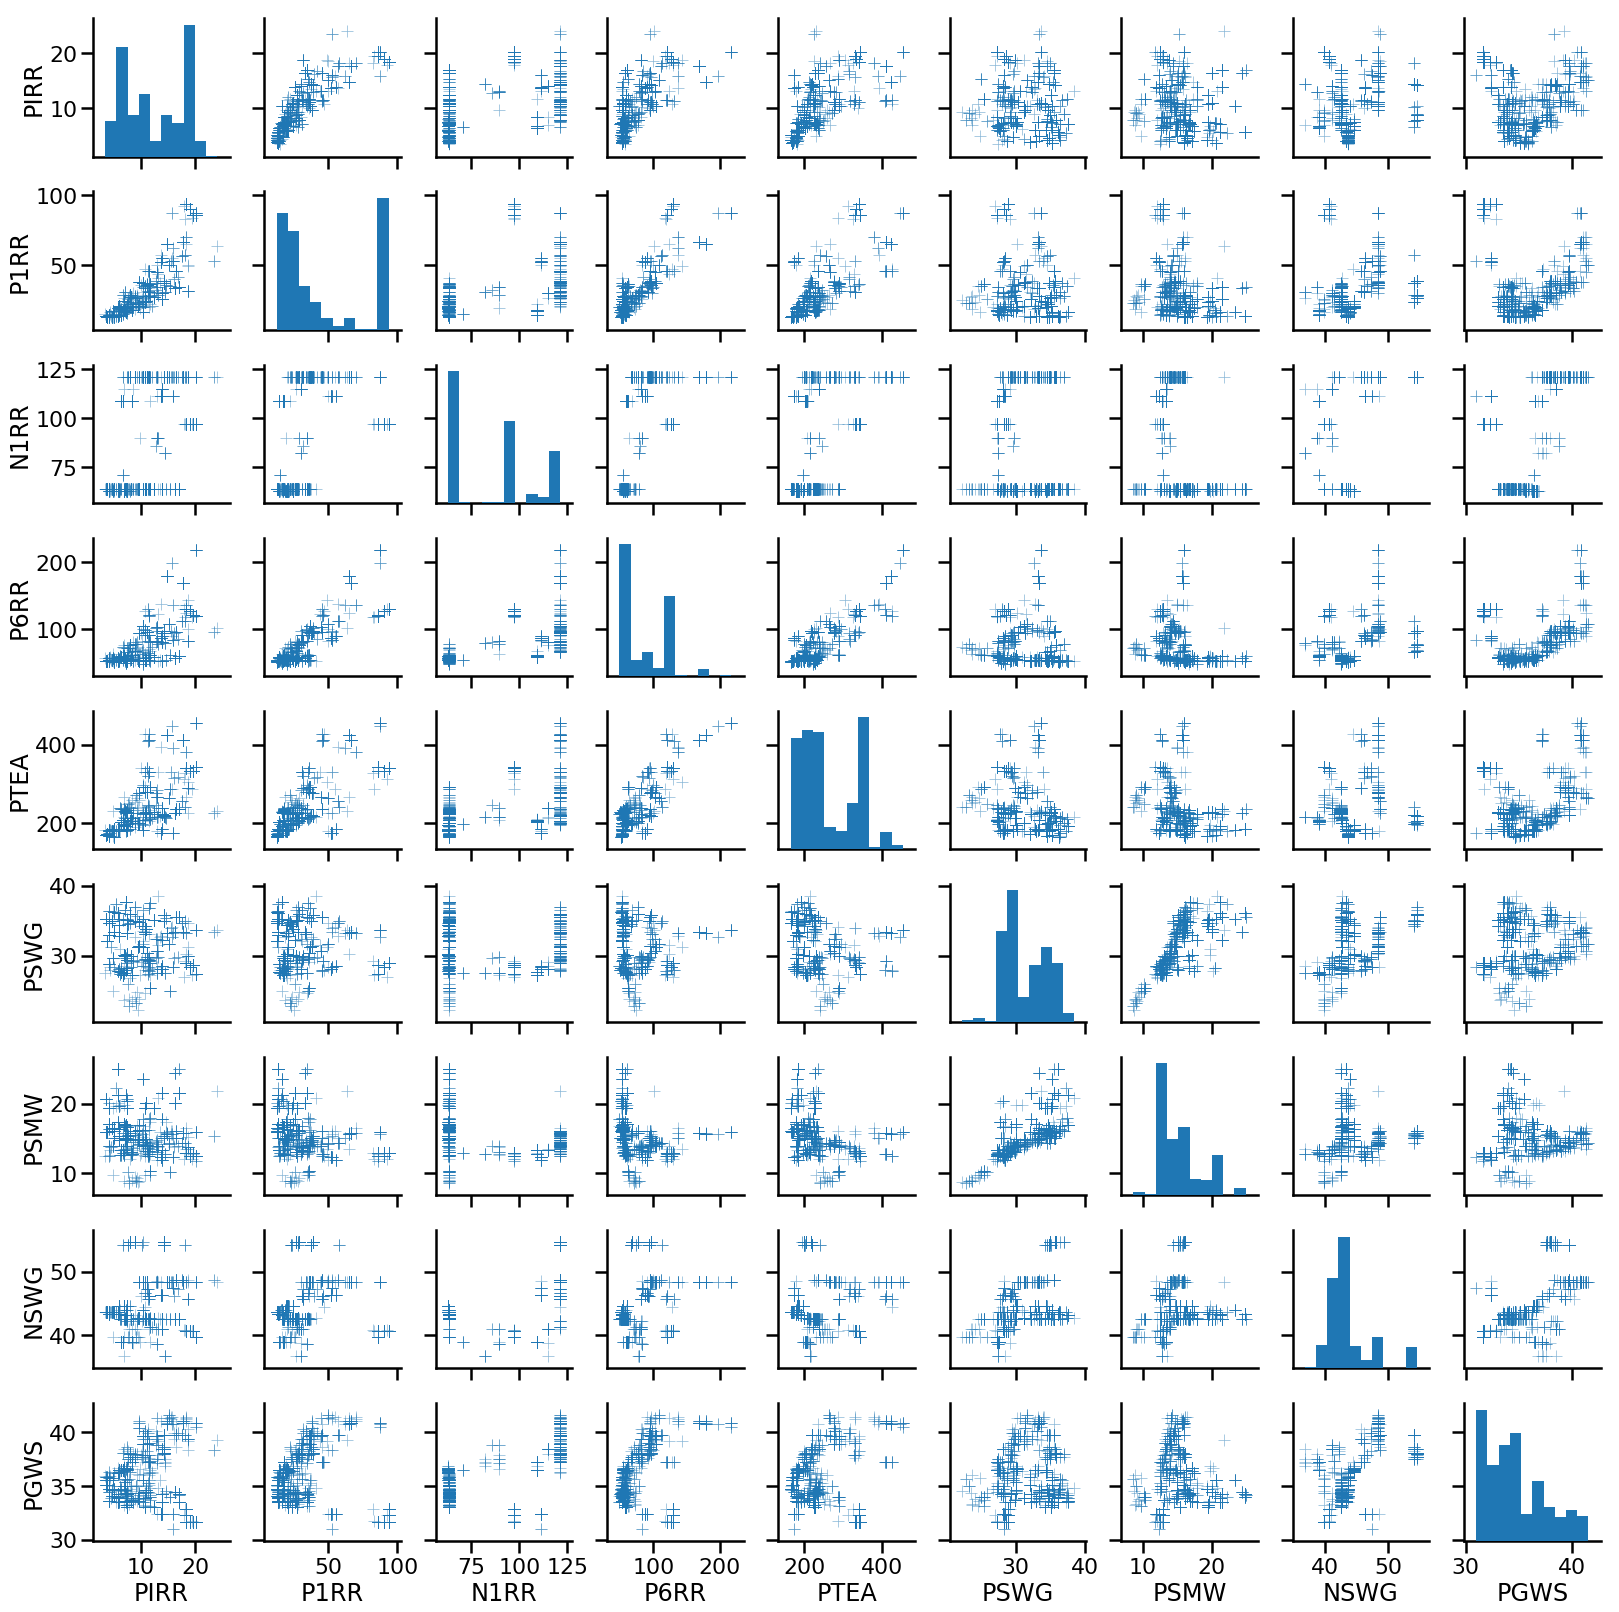

In [28]:
g = sns.pairplot(gdf[['PIRR', 'P1RR', 'N1RR', 'P6RR', 'PTEA', 'PSWG', 'PSMW', 'NSWG', 'PGWS']],
                 markers="+", plot_kws={'alpha':0.5})

In [23]:
gdf['EICU_Degda'].head()

0    Major Impact - 26-50%
1           No Damage - 0%
2           No Damage - 0%
3           No Damage - 0%
4           No Damage - 0%
Name: EICU_Degda, dtype: object